In [3]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [4]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,classification_report
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import torch

In [5]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
data_path = 'flipkart.csv'  # Adjust path if necessary
data = pd.read_csv(data_path)


In [8]:
print("Columns 'Review', 'Sentiment', and 'Rating' must be in the CSV file.")

Columns 'Review', 'Sentiment', and 'Rating' must be in the CSV file.


In [9]:
def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)
    text = text.lower()
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [10]:
data['Cleaned_Review'] = data['Review'].apply(preprocess_text)

In [11]:
def get_emoji_label(rating):
    if rating >= 4:
        return '😊'  # Happy
    elif rating == 3:
        return '😐'  # Neutral
    elif rating == 2:
        return '😕'  # Disappointed
    else:
        return '😡'  # Angry or very sad

data['Emoji'] = data['Rating'].apply(get_emoji_label)

In [14]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['Cleaned_Review'].tolist(), data['Sentiment'].tolist(), test_size=0.2, random_state=42
)

In [13]:
data['Sentiment'] = data['Rating'].apply(lambda x: 1 if x >= 3 else 0)

In [15]:
train_data = Dataset.from_dict({'text': train_texts, 'label': train_labels})
test_data = Dataset.from_dict({'text': test_texts, 'label': test_labels})


In [16]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=128)


In [18]:
train_data = train_data.map(preprocess_function, batched=True)
test_data = test_data.map(preprocess_function, batched=True)


Map:   0%|          | 0/1843 [00:00<?, ? examples/s]

Map:   0%|          | 0/461 [00:00<?, ? examples/s]

In [19]:
train_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_data.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

In [20]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

In [21]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,  # Adjust for higher accuracy if needed
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [22]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    compute_metrics=compute_metrics
)

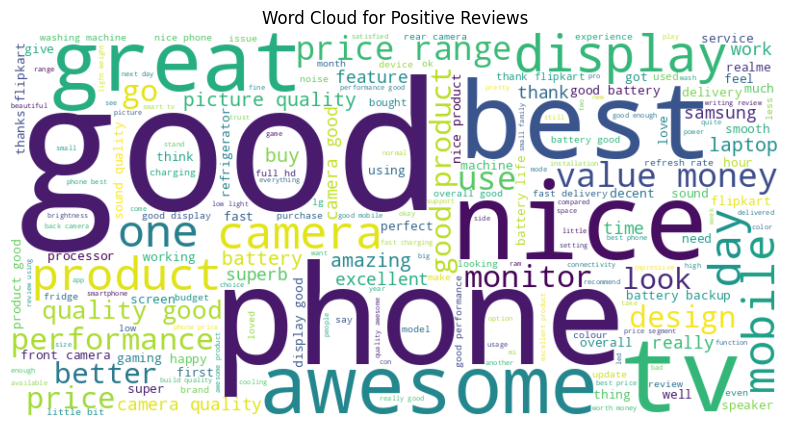

In [23]:
positive_reviews = ' '.join(data[data['Sentiment'] == 1]['Cleaned_Review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

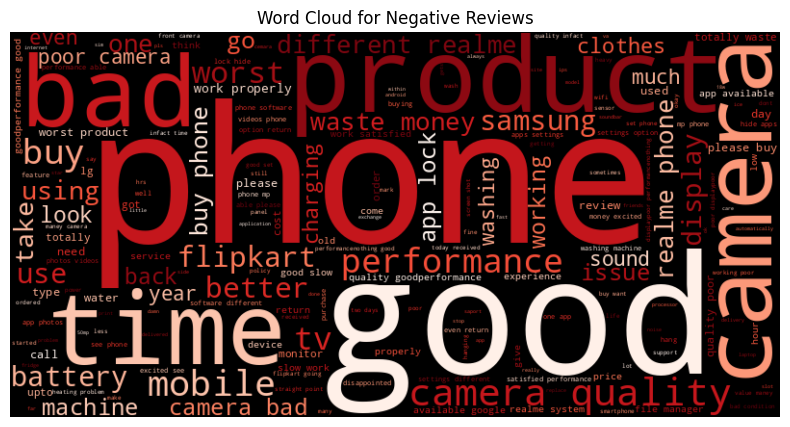

In [25]:
negative_reviews = ' '.join(data[data['Sentiment'] == 0]['Cleaned_Review'])
wordcloud_neg = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(negative_reviews)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()

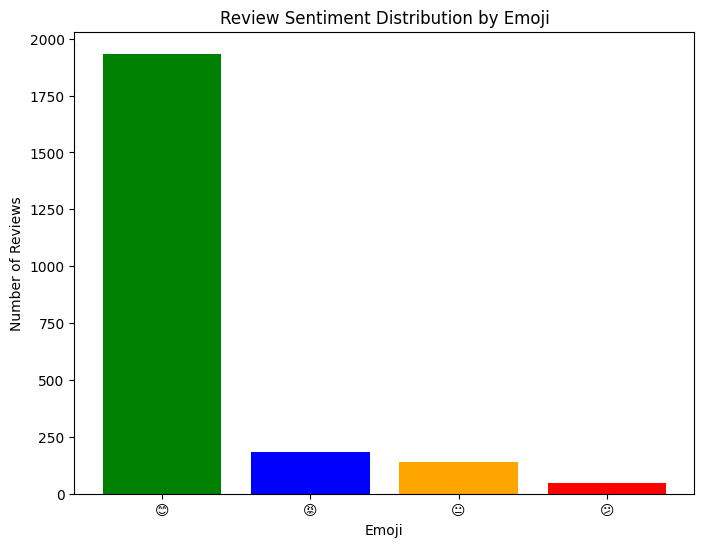

In [26]:
emoji_counts = data['Emoji'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(emoji_counts.index, emoji_counts.values, color=['green', 'blue', 'orange', 'red'])
plt.xlabel('Emoji')
plt.ylabel('Number of Reviews')
plt.title('Review Sentiment Distribution by Emoji')
plt.show()

In [49]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

In [50]:
print(f'Accuracy: {accuracy * 100:.2f}%')
print('Classification Report:')
print(classification_rep)

Accuracy: 93.71%
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.35      0.51        43
           1       0.94      1.00      0.97       418

    accuracy                           0.94       461
   macro avg       0.94      0.67      0.74       461
weighted avg       0.94      0.94      0.92       461



In [13]:
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(data['Cleaned_Review']).toarray()
y = data['Sentiment']  # Target variable (0 = Negative, 1 = Positive)

In [14]:
data = data.drop(columns=['Unnamed: 0'], errors='ignore')

In [15]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['Cleaned_Review'].tolist(), data['Sentiment'].tolist(), test_size=0.2, random_state=42
)


In [16]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding=True)



In [40]:
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(data['Cleaned_Review']).toarray()
y = data['Sentiment']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}


In [44]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

NameError: name 'classification_report' is not defined

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,  # Adjust if more epochs are needed
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding=True)

train_data = train_data.map(preprocess_function, batched=True)
test_data = test_data.map(preprocess_function, batched=True)


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=test_data,
    compute_metrics=compute_metrics
)

NameError: name 'train_data' is not defined

In [ ]:
train_data = Dataset.from_dict({'text': train_texts, 'label': train_labels})
test_data = Dataset.from_dict({'text': test_texts, 'label': test_labels})

NameError: name 'Dataset' is not defined

In [ ]:
data['Sentiment'] = data['Rating'].apply(lambda x: 1 if x >= 3 else 0)

In [ ]:
def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)
    text = text.lower()
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [ ]:
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(data['Cleaned_Review']).toarray()
y = data['Sentiment']  # Target variable (0 = Negative, 1 = Positive)

Available columns: Index(['Unnamed: 0', 'Product_name', 'Review', 'Rating', 'Cleaned_Review'], dtype='object')


In [ ]:
data['Cleaned_Review'] = data['Review'].apply(preprocess_text)

In [ ]:
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(data['Cleaned_Review']).toarray()
y = data['Sentiment']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

In [45]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

NameError: name 'classification_report' is not defined

In [ ]:
print(f'Accuracy: {accuracy * 100:.2f}%')
print('Classification Report:')
print(classification_rep)

Accuracy: 93.71%
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.35      0.51        43
           1       0.94      1.00      0.97       418

    accuracy                           0.94       461
   macro avg       0.94      0.67      0.74       461
weighted avg       0.94      0.94      0.92       461



In [2]:
positive_reviews = ' '.join(data[data['Sentiment'] == 1]['Cleaned_Review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

NameError: name 'data' is not defined

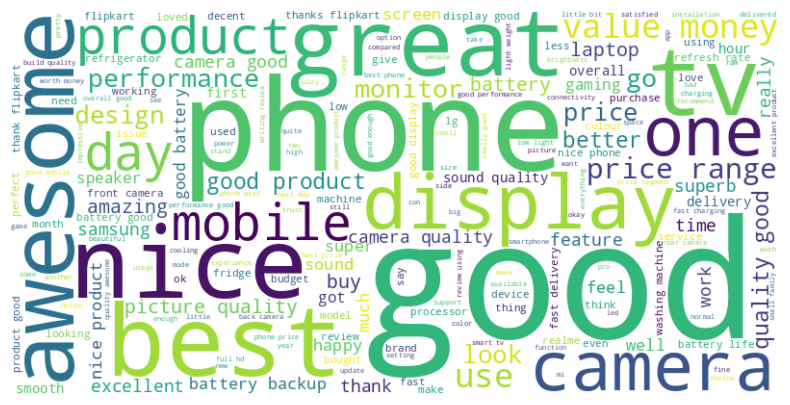

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [1]:
negative_reviews = ' '.join(data[data['Sentiment'] == 1]['Cleaned_Review'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)

NameError: name 'data' is not defined

In [ ]:
def get_emoji_label(rating):
    if rating >= 4:
        return '😊'  # Happy
    elif rating == 3:
        return '😐'  # Neutral
    elif rating == 2:
        return '😕'  # Disappointed
    else:
        return '😡'  # Angry or very sad

In [ ]:
data['Emoji'] = data['Rating'].apply(get_emoji_label)

# Count Reviews for Each Emoji
emoji_counts = data['Emoji'].value_counts()


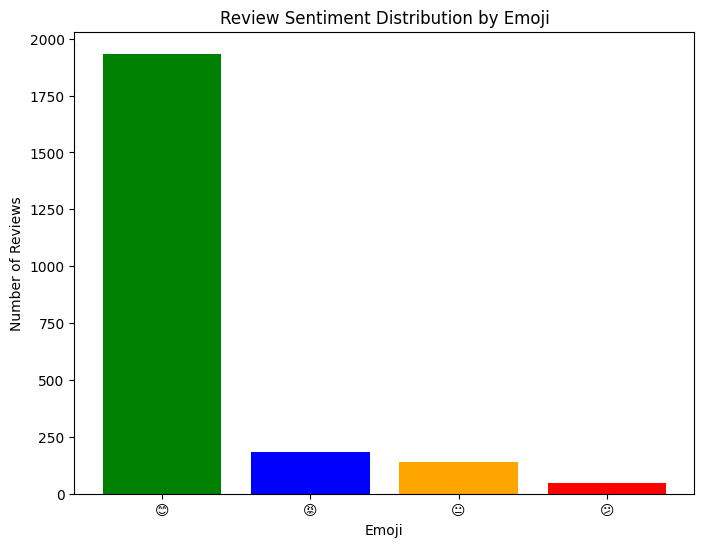

In [ ]:
plt.figure(figsize=(8, 6))
plt.bar(emoji_counts.index, emoji_counts.values, color=['green', 'blue', 'orange', 'red'])
plt.xlabel('Emoji')
plt.ylabel('Number of Reviews')
plt.title('Review Sentiment Distribution by Emoji')
plt.show()